In [1]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [3]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [4]:
len(numberbatch.vocab)

651859

In [5]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [6]:
ds_techniques = pd.read_csv('datasets/silknow/zeste_technique_es_post.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,Paño de damasco verde con flecos dorados y esp...,http://data.silknow.org/vocabulary/168
1,Edad Moderna,http://data.silknow.org/vocabulary/168
2,Palio de damasco en verde con aplicaciones de ...,http://data.silknow.org/vocabulary/168
3,Edad Moderna,http://data.silknow.org/vocabulary/168
4,Edad Moderna,http://data.silknow.org/vocabulary/168


In [7]:
ds_techniques.label.value_counts()

http://data.silknow.org/vocabulary/168    740
http://data.silknow.org/vocabulary/366    477
http://data.silknow.org/vocabulary/305    413
http://data.silknow.org/vocabulary/379    298
http://data.silknow.org/vocabulary/87     226
Name: label, dtype: int64

In [8]:
len(ds_techniques)

2154

In [9]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [10]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [11]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [12]:
sorted(ds_techniques.label.unique())

['http://data.silknow.org/vocabulary/168',
 'http://data.silknow.org/vocabulary/305',
 'http://data.silknow.org/vocabulary/366',
 'http://data.silknow.org/vocabulary/379',
 'http://data.silknow.org/vocabulary/87']

In [13]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [14]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 'http://data.silknow.org/vocabulary/168':'damasco',
            'http://data.silknow.org/vocabulary/366':'raso',
            'http://data.silknow.org/vocabulary/305':'lampás',  
           'http://data.silknow.org/vocabulary/379':'terciopelo',     
            'http://data.silknow.org/vocabulary/87':'bordado'}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

5
['bordado', 'damasco', 'lampás', 'raso', 'terciopelo']


In [15]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 91.8 ms, sys: 7.47 ms, total: 99.2 ms
Wall time: 94.4 ms


In [16]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'bordado': 79, 'damasco': 811, 'lampás': 5, 'raso': 422, 'terciopelo': 63}

In [17]:
labels_cgr.keys()

dict_keys(['bordado', 'damasco', 'lampás', 'raso', 'terciopelo'])

In [18]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [19]:
ds_techniques.text[0]

'Paño de damasco verde con flecos dorados y espiguilla.  Presenta decoración con motivos florales.'

In [20]:
data_silknow = ds_techniques.text.tolist()

In [21]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [22]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 211 ms, sys: 1.26 s, total: 1.47 s
Wall time: 2.44 s


In [23]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [24]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [25]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 0 ns, sys: 1.17 s, total: 1.17 s
Wall time: 1.17 s


In [26]:


predictions[:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0]

In [27]:

prediction_labels = [labels[p] for p in predictions]

In [28]:
set(prediction_labels)

{'bordado', 'damasco', 'lampás', 'raso', 'terciopelo'}

In [29]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Techniques

In [30]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('techniques-es-predictions.csv')

              precision    recall  f1-score   support

     bordado      0.907     0.116     0.205      1772
     damasco      0.130     0.464     0.203       207
      lampás      0.002     1.000     0.005         1
        raso      0.084     0.440     0.141        91
  terciopelo      0.245     0.880     0.383        83

    accuracy                          0.193      2154
   macro avg      0.274     0.580     0.187      2154
weighted avg      0.772     0.193     0.209      2154



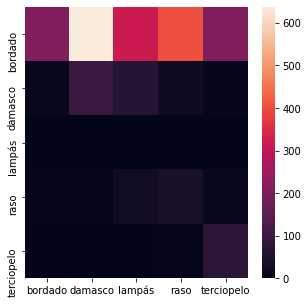

In [31]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [32]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     bordado      0.372     0.672     0.479       125
     damasco      0.134     0.503     0.211       197
      lampás      0.005     0.667     0.010         3
        raso      0.922     0.928     0.925       474
  terciopelo      0.980     0.215     0.353      1355

    accuracy                          0.426      2154
   macro avg      0.483     0.597     0.396      2154
weighted avg      0.853     0.426     0.473      2154



In [33]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     bordado      0.372     0.743     0.496       113
     damasco      0.135     0.575     0.219       174
      lampás      0.760     0.997     0.863       315
        raso      0.994     0.963     0.978       492
  terciopelo      0.997     0.280     0.437      1060

    accuracy                          0.589      2154
   macro avg      0.651     0.712     0.599      2154
weighted avg      0.859     0.589     0.609      2154



# 